In [1]:
from keras.models import Model
import tensorflow as tf
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.applications.mobilenet import MobileNet
from keras.applications import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
FULL_YOLO_BACKEND_PATH  = "full_yolo_backend.h5"   # should be hosted on a server
TINY_YOLO_BACKEND_PATH  = "tiny_yolo_backend.h5"   # should be hosted on a server
SQUEEZENET_BACKEND_PATH = "squeezenet_backend.h5"  # should be hosted on a server
MOBILENET_BACKEND_PATH  = "mobilenet_backend.h5"   # should be hosted on a server
INCEPTION3_BACKEND_PATH = "inception_backend.h5"   # should be hosted on a server
VGG16_BACKEND_PATH      = "vgg16_backend.h5"       # should be hosted on a server
RESNET50_BACKEND_PATH   = "resnet50_backend.h5"  

In [3]:
class BaseFeatureExtractor(object):
    
    def __init__( self, input_size ) :
        raise NotImplementedError("Error Message")
        
    def normalize( self, image ):
        raise NotImplementedError("Error Message ")
        
    def get_output_shape(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]

    def extract(self, input_image):
        return self.feature_extractor(input_image)

In [4]:
class FullYoloFeature(BaseFeatureExtractor):
    
    def __init__( self, input_size ):
        
        input_image = Input(shape = (input_size , input_size , 3))
        
        def space_to_depth_x2(x):
            return tf.nn.space_to_depth(x , block_size = 2 )
        
        
        def Conv_block( inputs  , filters , kernel_size = 3 , strides = 1 , name = 1 , use_bias = False , use_pooling= False   ):

            x = Conv2D(filters , kernel_size=(kernel_size , kernel_size) , strides=(strides , strides) ,
                      padding = 'same' , name = "conv_" + str(name) , use_bias=use_bias)(inputs)
            x = BatchNormalization(name = 'norm_' + str(name))(x)
            x = LeakyReLU(alpha=0.1)(x)
            if use_pooling:
                x = MaxPooling2D(pool_size=( 2 , 2 ))(x)
            return x 
        
        
        x = Conv_block(input_image ,32 , name = 1 , use_pooling = True)
        
        x = Conv_block( x , 64 , name =  2 , use_pooling = True )
        x = Conv_block( x , 128 , name =  3 , use_pooling=False)
        x = Conv_block( x , 64 ,  name =  4 , use_pooling=False )
        
        x = Conv_block( x , 128 , name =  5 , use_pooling=True)
        x = Conv_block( x , 256 , name =  6 , use_pooling=False)
        x = Conv_block( x , 128 ,  name =  7 , use_pooling=False )
        
        
        x = Conv_block( x , 256 , name =  8 , use_pooling=True)
        x = Conv_block( x , 512 , name =  9 , use_pooling=False)
        x = Conv_block( x , 256 ,  name = 10 , use_pooling=False )
        
        
        x = Conv_block( x , 512 , name =  11 , use_pooling=False)
        x = Conv_block( x , 256 ,  name = 12 , use_pooling=False )
        
        
        x = Conv_block( x , 512 , name =  13 , use_pooling=False)
        
        skip_connection  =  x
        x = MaxPooling2D(pool_size=( 2 , 2 ))(x)
        
        
        x = Conv_block( x , 1024 , kernel_size= 3 ,name =  14 , use_pooling=False)
        x = Conv_block( x , 512 , kernel_size= 1 ,name =  15 , use_pooling=False)
        x = Conv_block( x , 1024 , kernel_size= 3 ,name =  16 , use_pooling=False)
        x = Conv_block( x , 512 , kernel_size= 1 ,name =  17 , use_pooling=False)
        
        x = Conv_block( x , 1024 , kernel_size= 3 ,name =  18 , use_pooling=False)
        x = Conv_block( x , 1024 , kernel_size= 3 ,name =  19 , use_pooling=False)
        x = Conv_block( x , 1024 , kernel_size= 3 ,name =  20 , use_pooling=False)
       
    
        skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
        skip_connection = BatchNormalization(name='norm_21')(skip_connection)
        skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
        skip_connection = Lambda(space_to_depth_x2)(skip_connection)
        
        x = concatenate([skip_connection, x])
        
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
        x = BatchNormalization(name='norm_22')(x)
        x = LeakyReLU(alpha=0.1)(x)
        
        
        self.feature_extractor = Model(input_image, x) 
        #self.feature_extractor.load_weights(FULL_YOLO_BACKEND_PATH)
        
        
    
    def normalize( self, image ):
        return image /255.
        
        
                    
            

In [5]:
inputs_value = Input([512 , 512 , 3 ])
model = FullYoloFeature(512)

In [6]:
model.feature_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 512, 512, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 512, 512, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512, 512, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

In [7]:
class  TinyYoloFeature(BaseFeatureExtractor):
    
    def __init__( self, input_size ):
        
        input_image  = Input(shape= ( input_size , input_size , 3 ))
        
        def Conv_Block(inputs , filters , kernel_size = 3 , stride = 1 , padding = 'same' , name = 1, use_bias = False  , use_maxpooling = False):
            
            x = Conv2D( filters , (kernel_size , kernel_size) , strides=stride , padding = padding , name = 'conv_'+ str(name), use_bias = False )(inputs)
            x = BatchNormalization(name = 'nor_' + str(name))(x)
            x = LeakyReLU(alpha=0.1)(x)
            if use_maxpooling:
                x = MaxPooling2D(pool_size=(2,2))(x)
            return x
        
        
        x = Conv_Block(input_image , 16 , kernel_size=3 , stride=1 , padding='same', name = 1, use_bias=False , use_maxpooling=True )
        
        for i in range(0 ,4):
            x = Conv_Block(x , 32*(2**i) , kernel_size=3 , stride= 1 , padding='same', name = i+2 , use_bias=False , use_maxpooling=True )
            
        
        x = Conv_Block( x , 512 , kernel_size= 3 , name = 6 ,  use_bias= False , use_maxpooling=True )
        
        for i  in range(0,2 ):
            x = Conv_Block( x , 1024 , kernel_size=3 , name = (i+7) , use_maxpooling=True )
        
        self.feature_extractor = Model(input_image, x)  
        #self.feature_extractor.load_weights(TINY_YOLO_BACKEND_PATH)
        
    def normalize( self, image ):
        return image /255.
        

In [8]:
model = TinyYoloFeature(512)

In [9]:
model.feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 512, 512, 16)      432       
_________________________________________________________________
nor_1 (BatchNormalization)   (None, 512, 512, 16)      64        
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 512, 512, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 256, 256, 32)      4608      
_________________________________________________________________
nor_2 (BatchNormalization)   (None, 256, 256, 32)      128 

In [10]:
class MobileNetFeature(BaseFeatureExtractor):
    
    def __init__( self, input_size ):
        
        input_image  =  Input(shape = (input_size , input_size , 3 ))
        mobilenet    =  MobileNet(input_shape = (244 , 244 , 3 ) , include_top = False )
        #mobilenet.load_weights(MOBILENET_BACKEND_PATH)
        x = mobilenet(input_image)
        
        self.feature_extractor = Model(input_image, x) 
        
        
    
    def normalize(self, image):
        image = image / 255.
        image = image  - 0.5
        image = image *2.
        return image
    

        


In [11]:
model = MobileNetFeature(512)
model.feature_extractor.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   multiple                  3228864   
Total params: 3,228,864
Trainable params: 3,206,976
Non-trainable params: 21,888
_________________________________________________________________


In [12]:
class SqueezeNetFeature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):

        # define some auxiliary variables and the fire module
        sq1x1  = "squeeze1x1"
        exp1x1 = "expand1x1"
        exp3x3 = "expand3x3"
        relu   = "relu_"

        def fire_module(x, fire_id, squeeze=16, expand=64):
            s_id = 'fire' + str(fire_id) + '/'

            x     = Conv2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
            x     = Activation('relu', name=s_id + relu + sq1x1)(x)

            left  = Conv2D(expand,  (1, 1), padding='valid', name=s_id + exp1x1)(x)
            left  = Activation('relu', name=s_id + relu + exp1x1)(left)

            right = Conv2D(expand,  (3, 3), padding='same',  name=s_id + exp3x3)(x)
            right = Activation('relu', name=s_id + relu + exp3x3)(right)

            x = concatenate([left, right], axis=3, name=s_id + 'concat')

            return x

        # define the model of SqueezeNet
        input_image = Input(shape=(input_size, input_size, 3))

        x = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(input_image)
        x = Activation('relu', name='relu_conv1')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

        x = fire_module(x, fire_id=2, squeeze=16, expand=64)
        x = fire_module(x, fire_id=3, squeeze=16, expand=64)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

        x = fire_module(x, fire_id=4, squeeze=32, expand=128)
        x = fire_module(x, fire_id=5, squeeze=32, expand=128)
        x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

        x = fire_module(x, fire_id=6, squeeze=48, expand=192)
        x = fire_module(x, fire_id=7, squeeze=48, expand=192)
        x = fire_module(x, fire_id=8, squeeze=64, expand=256)
        x = fire_module(x, fire_id=9, squeeze=64, expand=256)

        self.feature_extractor = Model(input_image, x)  
        #self.feature_extractor.load_weights(SQUEEZENET_BACKEND_PATH)

    def normalize(self, image):
        image = image[..., ::-1]
        image = image.astype('float')

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68

        return image    


In [13]:
model = SqueezeNetFeature(512)
model.feature_extractor.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 255, 255, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 255, 255, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 127, 127, 64) 0           relu_conv1[0][0]                 
____________________________________________________________________________________________

In [14]:
class Inception3Feature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))

        inception = InceptionV3(input_shape=(input_size,input_size,3), include_top=False)
        #inception.load_weights(INCEPTION3_BACKEND_PATH)

        x = inception(input_image)

        self.feature_extractor = Model(input_image, x)  

    def normalize(self, image):
        image = image / 255.
        image = image - 0.5
        image = image * 2.

        return image

In [15]:
model = Inception3Feature(512)
model.feature_extractor.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [16]:
class VGG16Feature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        vgg16 = VGG16(input_shape=(input_size, input_size, 3), include_top=False)
        #vgg16.load_weights(VGG16_BACKEND_PATH)

        self.feature_extractor = vgg16

    def normalize(self, image):
        image = image[..., ::-1]
        image = image.astype('float')

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68

        return image 


In [17]:
model = VGG16Feature(512)
model.feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [18]:
class ResNet50Feature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        resnet50 = ResNet50(input_shape=(input_size, input_size, 3), include_top=False)
        resnet50.layers.pop() # remove the average pooling layer
        #resnet50.load_weights(RESNET50_BACKEND_PATH)

        self.feature_extractor = Model(resnet50.layers[0].input, resnet50.layers[-1].output)

    def normalize(self, image):
        image = image[..., ::-1]
        image = image.astype('float')

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68
        return image

In [19]:
model = ResNet50Feature(512)
model.feature_extractor.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [20]:
import os
import numpy as np
import xml.etree.ElementTree as ET

In [21]:
data_path = "D:/temp/yolo/raccoon_dataset-master/raccoon_dataset-master/"
images_path = os.path.join( data_path , 'images/')
ann_path = os.path.join(data_path , 'annotations/')

In [22]:
images_path

'D:/temp/yolo/raccoon_dataset-master/raccoon_dataset-master/images/'

In [23]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

In [24]:
all_images , seen_labels = parse_annotation(ann_path , images_path )

In [25]:
seen_labels

{'raccoon': 217}

In [26]:
print(all_images[6])

{'object': [{'name': 'raccoon', 'xmin': 189, 'ymin': 41, 'xmax': 340, 'ymax': 249}], 'filename': 'D:/temp/yolo/raccoon_dataset-master/raccoon_dataset-master/images/raccoon-104.jpg', 'width': 600, 'height': 304}


In [27]:

LABELS = ['raccoon']

IMAGE_H, IMAGE_W = 416, 416

GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)

CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [28]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [29]:
generator_config

{'IMAGE_H': 416,
 'IMAGE_W': 416,
 'GRID_H': 13,
 'GRID_W': 13,
 'BOX': 5,
 'LABELS': ['raccoon'],
 'CLASS': 1,
 'ANCHORS': [0.57273,
  0.677385,
  1.87446,
  2.06253,
  3.33843,
  5.47434,
  7.88282,
  3.52778,
  9.77052,
  9.16828],
 'BATCH_SIZE': 16,
 'TRUE_BOX_BUFFER': 50}

In [30]:
class BoundBox:
    
    def __init__(self, xmin, ymin , xmax , ymax , c = None , classes = None  ):
        
        self.xmin = xmin
        self.xmax = xmax 
        self.ymin = ymin
        self.ymax = ymax
        
        self.c  = c
        self.classes  = classes
        
        self.label =  -1
        self.score =  -1
        
        
        
    def get_label(self, ):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label
    
    def get_score(self,):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

In [58]:
def _interval_overlap( interval_a , interval_b ):
    x1 , x2 = interval_a
    x3 , x4 = interval_b
    
    if x3 < x1 :
        if x4 < x1 :
            return 0
        else:
            return min( x2 , x4 ) - x1
    else:
        
        if x2 < x3 :
            return 0
        else:
            return min( x2 , x4) - x3
        
        
        

def bbox_iou( bbox1 , bbox2 ):
    intersect_w = _interval_overlap([bbox1.xmin , bbox1.xmax] , [bbox2.xmin , bbox2.xmax ])
    intersect_h = _interval_overlap([bbox1.ymin , bbox1.ymax] , [bbox2.ymin , bbox2.ymax ])
    
    intersect_area = intersect_h*intersect_w
    
    w1 , h1 = bbox1.xmax - bbox1.xmin , bbox1.ymax - bbox1.ymin
    w2 , h2 = bbox2.xmax - bbox2.xmin , bbox2.ymax - bbox2.ymin
    
    union_area = w1*h1 + w2*h2  - intersect_area
    return float(intersect_area)/union_area


    

In [72]:
import imgaug as ia
from imgaug import augmenters as iaa
from keras.utils import Sequence
import cv2
import matplotlib.pyplot as plt
import copy

In [60]:
help(Sequence)

Help on class Sequence in module keras.utils.data_utils:

class Sequence(builtins.object)
 |  Base object for fitting to a sequence of data, such as a dataset.
 |  
 |  Every `Sequence` must implement the `__getitem__` and the `__len__` methods.
 |  If you want to modify your dataset between epochs you may implement
 |  `on_epoch_end`. The method `__getitem__` should return a complete batch.
 |  
 |  # Notes
 |  
 |  `Sequence` are a safer way to do multiprocessing. This structure guarantees
 |  that the network will only train once on each sample per epoch which is not
 |  the case with generators.
 |  
 |  # Examples
 |  
 |  ```python
 |      from skimage.io import imread
 |      from skimage.transform import resize
 |      import numpy as np
 |  
 |      # Here, `x_set` is list of path to the images
 |      # and `y_set` are the associated classes.
 |  
 |      class CIFAR10Sequence(Sequence):
 |  
 |          def __init__(self, x_set, y_set, batch_size):
 |              self.x, se

In [103]:
class BatchGenerator(Sequence):
    
    def __init__( self, all_images_data , config , shuffle = True ,
                jitter = True , norm = None ):
        
        self.generator = None
        self.all_images_data = all_images_data
        self.config = config
        
        
        
        self.shuffle = shuffle
        self.jitter =  jitter
        
        self.norm = norm
        #self.anchors = []
        
        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        
        ##### Augmentors 
        sometimes = lambda aug : iaa.Sometimes(0.5 , aug )
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                #iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    #rotate=(-5, 5), # rotate by -45 to +45 degrees
                    #shear=(-5, 5), # shear by -16 to +16 degrees
                    #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges
                        #sometimes(iaa.OneOf([
                        #    iaa.EdgeDetect(alpha=(0, 0.7)),
                        #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                        #])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        #iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        #iaa.Grayscale(alpha=(0.0, 1.0)),
                        #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: 
            np.random.shuffle(self.all_images_data)
            
            
    def __len__(self):
        return int(np.ceil(float(len(self.all_images_data))/self.config['BATCH_SIZE']))
    
    def num_classes(self):
        return len(self.config['LABELS'])
    
    
    def size(self):
        return len(self.all_images_data)
    
    def load_annotation_data(self , idx_number ):
        annots_lst = []
        
        for obj in self.all_images_data[idx_number]['object']:
            ann = [ obj['xmin'] , obj['ymin'] , obj['xmax'] , obj['ymax'] , self.config['LABELS'].index(obj['name'])]
            annots_lst += ann
            
        
        if len(annots_lst) == 0:
            annots_lst = [[]]
            
        return np.array(annots_lst)
    
    def load_image(self, idx_number ):
        return cv2.imread(self.all_images_data[idx_number]['filename'])
    
    
    def __getitem__(self, idx ):
        
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx + 1) *self.config['BATCH_SIZE']
        
        if r_bound > len(self.all_images_data):
            r_bound = len(self.all_images_data)
            l_bound = r_bound - self.config['BATCH_SIZE']
            
        instance_count = 0
        
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'] , self.config['IMAGE_W'] , 3 ))
        b_batch = np.zeros((r_bound - l_bound , 1 , 1 , 1 , self.config['TRUE_BOX_BUFFER'] , 4 ))
        y_batch = np.zeros((r_bound - l_bound , self.config['GRID_H'] , self.config['GRID_W'] , self.config['BOX'] ,  
                            4+1+len(self.config['LABELS'] )))
        
        
        for train_instance in self.all_images_data[l_bound : r_bound]:
            
            img  , all_objs = self.aug_image(train_instance, jitter = self.jitter)
            
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and self.config['LABELS']:
                    
                    center_x = 0.5*(obj['xmax'] + obj['xmin'])
                    center_x = center_x / (float(self.config['IMAGE_W'])/self.config['GRID_W'])
                    
                    
                    center_y = 0.5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H'])/self.config['GRID_H'])
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))
                    
                    
                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        
                        obj_indx = self.config['LABELS'].index(obj['name'])
                        
                        center_w = (obj['xmax'] - obj['xmin']) / ( float(self.config['IMAGE_W']) / self.config['GRID_W'])
                        center_h = (obj['ymax'] - obj['ymin']) / ( float(self.config['IMAGE_H']) / self.config['GRID_H'])
                        
                        box = [center_x , center_y , center_w , center_h ]
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = BoundBox( 0 , 0 , center_w , center_h )
                        
                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou = bbox_iou( shifted_box , anchor)
                            if max_iou < iou :
                                best_anchor = i 
                                max_iou = iou
                                
                        y_batch[instance_count , grid_x , grid_y , best_anchor , 0:4 ] = box
                        y_batch[instance_count , grid_x , grid_y , best_anchor , 4 ] = 1.
                        y_batch[instance_count , grid_x,  grid_y , best_anchor , 5 + obj_indx ] = 1
                        
                        
                        b_batch[instance_count , 0 ,0 , 0 , true_box_index ] = box
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                        
            if self.norm != None:
                x_batch[instance_count] = self.norm(img)
            else:
                
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'], (obj['xmin']+2, obj['ymin']+12), 0, 1.2e-3 * img.shape[0],(0,255,0), 2)
                
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.show()
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1  

        #print(' new batch created', idx)

        return [x_batch, b_batch], y_batch
                            
        
        
    
    def aug_image( self, train_instance ,  jitter ):
        
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        
        if image is None:
            print("Cannot find " , image_name )
            
        
        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])
        
        if jitter:
            
            ### scale the image
            scale = np.random.uniform()/10. + 1
            image = cv2.resize(image , ( 0,0 ) , fx = scale , fy = scale )
            
            ### translate the image
            max_offx = (scale - 1.)*w
            max_pffy = (scale - 1.)*h
            
            offx = int(np.random.uniform()*max_offx)
            offy = int(np.random.uniform()*max_pffy)
            
            image = image[offy : (offy + h) , offx : (offx + w)]
            
            ###flip the image
            flip = np.random.binomial( 1 , 0.5 )
            if flip>0.5 :
                image = cv2.flip(image , 1 )
            
            image = self.aug_pipe.augment_image(image)
            
        
        image = cv2.resize(image , (self.config['IMAGE_H'] , self.config['IMAGE_W']))
        image = image[:,: ,::-1]
        
        
        for obj in all_objs:
            for attr in ['xmin' , 'xmax']:
                
                if jitter : 
                    obj[attr] = int(obj[attr]*scale - offx)
                    
                obj[attr] = int(obj[attr]*float(self.config['IMAGE_H'])/h)
                obj[attr] = max( min(obj[attr] , self.config['IMAGE_H'] ) , 0 )
                
            for attr in ['ymin' , 'ymax']:
                
                if jitter:
                    obj[attr] = int(obj[attr]*scale - offy)
                    
                obj[attr] = int(obj[attr]*float(self.config['IMAGE_H'])/h)
                obj[attr] = max(min( obj[attr] , self.config['IMAGE_H']) , 0)
                
            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] -xmin
                
        return image , all_objs
    
    
    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)
                
        

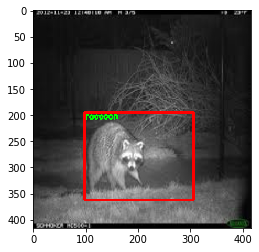

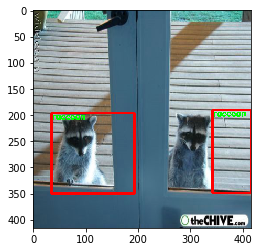

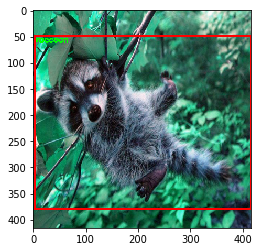

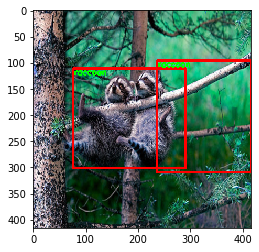

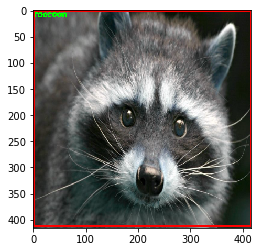

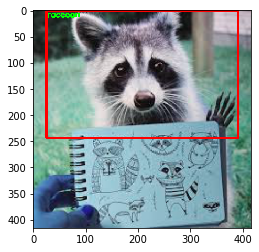

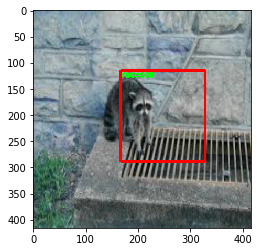

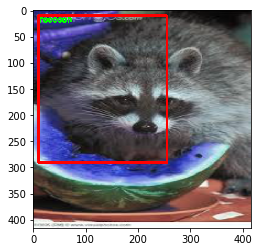

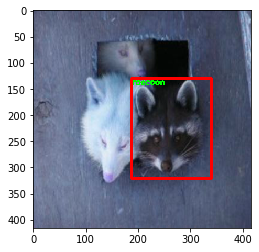

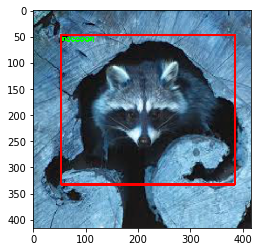

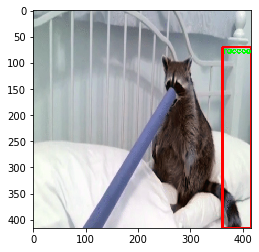

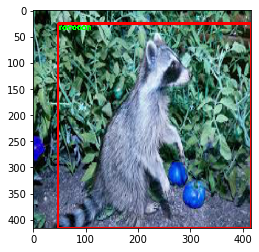

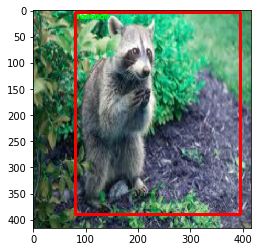

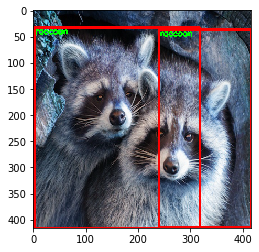

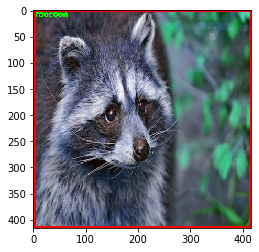

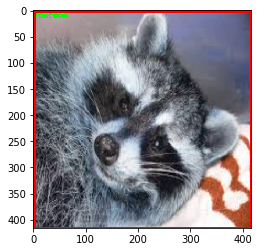

In [104]:
obj = BatchGenerator(all_images , generator_config , jitter = False )
itm = obj.__getitem__(8)